# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
# import torch
# import gpytorch as gpt
# from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In [12]:
train_x = np.linspace(0, 1, 108)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
], -1)

In [13]:
train_x.shape, train_y.shape

((108,), (108, 2))

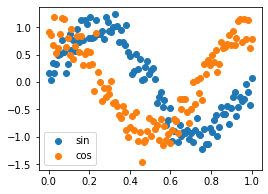

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
plt.legend(["sin", "cos"])

In [18]:
x = train_x
xx = np.concatenate((x, x), axis=0)
n = len(x)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((train_y[:,0], train_y[:,1]))
x.shape, X.shape, y.shape

((108, 1), (216, 2), (216,))

### Pymc model

In [41]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_54092/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))


In [42]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 158 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 7min 56s, sys: 12min 56s, total: 20min 53s
Wall time: 2min 41s


In [43]:
x_new = np.linspace(-1, 2, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_tracepreds = gp.conditional("preds", X_new), var_names=['preds'], random_seed=42)

ValueError: Variable name preds already exists.

In [ ]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

plot_gp_dist(ax, f_pred[:,200:], X_new[200:,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

In [ ]:
az.plot_trace(gp_trace);